# Car brand classification report

## Summary

1. [Introduction](#introduction)
2. [Data analysis](#dataanalysis)
    1. [Exploring the subject](#2.1)
    2. [Generating the dataset](#2.2)
    3. [Data exploration & analysis](#2.3)
3. [Data preprocessing](#datapreprocessing)
    1. [Label encoding & data prep](#3.1)
    2. [Split train & validation set](#3.2)
4. [First neural network training](#4)
    1. [Linear classification](#4.1)
    2. [Multi Layer Pereceptron](#4.2)
    3. [Support Vector Machine](#4.3)
5. [Improve the neural network](#5)
    1. [Data augmentation](#5.1)
    2. [Intuitions](#5.2)
6. [Prediction & submissions](#6)
    1. [Predict & submit results](#6.1)
7. [Conclusion](#ccl)

<a id="introduction"></a>
## 1. Introduction

This report aims to explain how te evaluate various model for a same problematic : **Car brand prediction with an image dataset**.
We'll be exploring various models and training various one te interpret which one is the most accurate. Then we'll explain intuition that led us to several way to imrove data and therefore the **model**.

The best model we manage to produce had an **A FAIRE** accuracy.

This notebook contains three four part:
* Data analysis
* Data preprocessing
* First neural networks training and evaluation
* Neural network and data improvement


<a id="dataanalysis"></a>
## 2. Data analysis

This part will describe how the data was scrapped and generated and also will be explored to know the repartition of each car brand in the dataset.

<a id="2.1"></a>
### 2.1 Exploring the subject

**First approach**
First of all, in order to retrieve numerous images of a car from a specific brand we decide to create a bot to scrap google images with search such as 'audi front' or 'mercedes'.

The results were not good with too many unrevelant photos and bad quality:

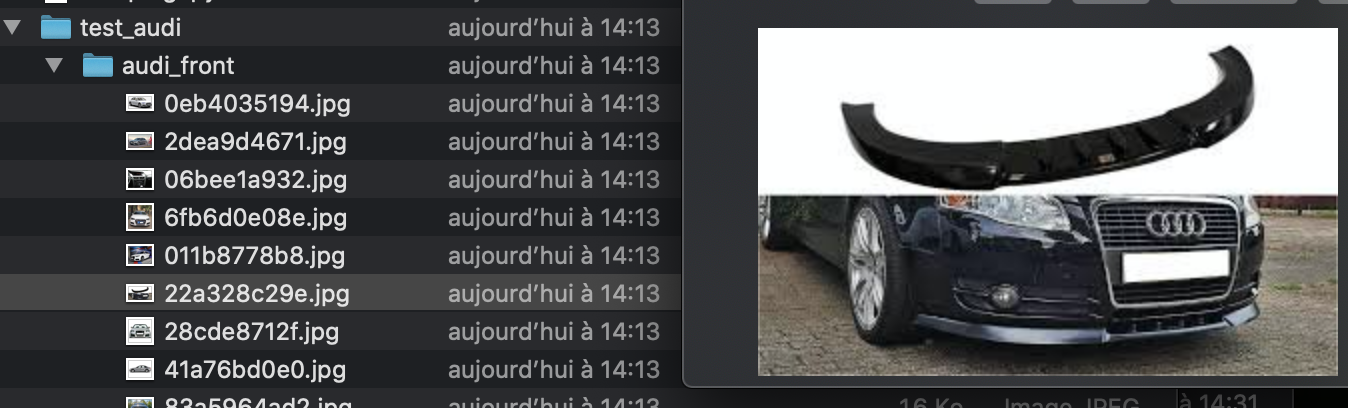

In [10]:
#
# Firstly we import necessary libs
#
import selenium
import os
import io
import time
import requests
import hashlib
from PIL import Image
from selenium import webdriver
DRIVER_PATH = '/Users/Damien/Documents/chromedriver' # Chromedriver path required


#
# Fetch all images url's from a specific gogole search
#

def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

#
# Utility function to save images form url in a folder
#

def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")
        
#
# Combine fetch url and save image utility functions into a more practical to use function
#

def search_and_download(search_term:str,driver_path:str,target_path='./images',number_images=5):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5)
        
    for elem in res:
        persist_image(target_folder,elem)

# Example of usage => search_and_download('audi front', DRIVER_PATH, './dataset', 60)

<a id="2.2"></a>
### 2.2 Generating the dataset

**Second approach**

From then on we wanted to base ourselves on the images of the car ad site.
By dint of searching we found the site carizy.com which offered a strong formalised layout for pictures.
By studying the site we found that the photos were hosted on a CDN with a formalised structure for each angle (front hood).
So we set up a script to retrieve quality images on the brands we wanted with the right angle. By doing so we could iterate over brands and also over angles of the car.

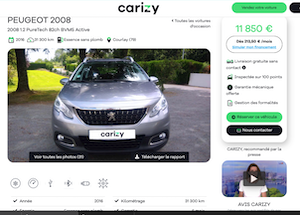

In [8]:
#
# Import necessary dependencies
#
import time
import requests
import os
import io
from PIL import Image
import hashlib

#
# Define a car data class that retrieve the useful data
#

class CarData:
    def __init__(self, car_id, url, img):
        self.car_id = car_id
        self.url = url
        self.img = img
        
    def __repr__(self):
        return str(self.car_id) + " : " + self.url + ' + ' + self.img
    
#
# Request the search api of the website with good params
#

def send_algolia_request(page):
    url = 'https://65quub6n61-dsn.algolia.net/1/indexes/*/queries?x-algolia-agent=Algolia%20for%20vanilla%20JavaScript%20(lite)%203.18.1%3Binstantsearch.js%201.8.11&x-algolia-application-id=65QUUB6N61&x-algolia-api-key=9ce4fd3eb414de32d0985b9b5a394448'
    data = {'requests': [{'indexName' : 'CarAlgoliaIndex_prod', 'params': 'query=&hitsPerPage=21&maxValuesPerFacet=100&page='+ str(page) +'&facets=%5B%22make%22%2C%22model%22%2C%22body%22%2C%22registartionDate%22%2C%22color%22%2C%22gear%22%2C%22fuel%22%2C%22price%22%2C%22monthly%22%2C%22kilometers%22%2C%22district%22%2C%22districtName%22%2C%22city%22%2C%22seats%22%2C%22isScrapPremium%22%5D&tagFilters='}]}
    p = requests.post(url, json=data)
    return p.json()

#
# map data to keep only useful data
#

def map_data(_car_data, hits):
    for e in hits:
        if e['make'] in _car_data:
            _car_data[e['make']].append(CarData(e['carId'], e['lien'], e['photo']))
        else:
            _car_data[e['make']] = [CarData(e['carId'], e['lien'], e['photo'])]

#
# Make all the request with a interval to avoid api blocking
#            
            
car_data = {}
i = 0
while i < 48:
    x = send_algolia_request(i)
    map_data(car_data, x['results'][0]['hits'])
    i += 1
    time.sleep(1)
   


#
# Utility function to download the images
#

def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")
 
#
# Final function that takes brand and angle paramaters
#

def download_brand_angle_img(brand, angle):
    urls = []
    for x in car_data[brand]:
        
        ur = x.img.replace('avant-gauche', angle)
        finalurl = 'https://cdn.carizy.com/carphotos/' + str(x.car_id) + '/wide/' + ur
        urls.append(finalurl)
    
    #folder_url = '/' + brand + '/' + angle
    folder_url = './cars'
    for z in urls:
        persist_image(folder_url, z)
        time.sleep(1)

#Example of usage => download_brand_angle_img('AUDI', 'face-capot')


<a id="2.3"></a>
### 2.3 Data exploration & analysis

In this part we will be exploring our dataset and analyze the repartition of each brand in order to be able to evaluate the accurcay of our future model.

In [1]:
# Firstly import all important libraries even for further work
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
import tensorflow.keras.preprocessing
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.utils import model_to_dot
import os
%matplotlib inline
import matplotlib.pyplot as plot
import cv2
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
import pandas as pd
import imageio

print('Dependencies imported')


Dependencies imported


<div class="alert alert-block alert-info">
Now, We need to prepare our data to feed into the model.
Following is the gernalized function used to extract data from the directory.
</div>

In [2]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Peugeot, 1 for Renault, 2 for Volkswagen
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'peugeot': #Folder contain peugeot picture get label 0
            label = 0
        elif labels == 'renault':
            label = 1
        elif labels == 'volkswagen':
            label = 2

        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(128,128)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
            
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset

def get_classlabel(class_code):
    labels = {0:'peugeot', 1:'renault', 2:'volkswagen'}
    
    return labels[class_code]


In [4]:
Images, Labels = get_images('../../Dataset/Raw/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)
print('Dataset loaded')

Dataset loaded


<div class="alert alert-block alert-info">
Lets find shape of our traing data.
The Training data is in shape of (Number of Training Images, Width of image, Height of image, Channel of image). This shape is very important. If we did not resize the images to same size. It should be (No. of images,) shape. So, using this shape we cant feed the images to the model
</div>

In [5]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (407, 128, 128, 3)
Shape of Labels: (407,)


<div class="alert alert-block alert-info">
So we have <strong>407</strong> pictures sized of 128 x 128 px with a 3 dimension for RGB. These are already <strong>normalized</strong> to a 128x128 matrix.<br>
Let's have a look to some random images of our dataset just for pleasure:
</div>

<div class="alert alert-block alert-info">
For any image specific classification, clustering, etc. transforms we'll want to collapse spatial dimensions so that we have a matrix of pixels by color channels.
</div>

In [6]:
first = plot.imread('../../Dataset/Raw/peugeot/0a58a0ca4f.jpg_resized.jpg')
dims = np.shape(first)
print(dims)
np.min(first), np.max(first)


(128, 128, 3)


(0, 255)

<div class="alert alert-block alert-info">
For any image specific classification, clustering, etc. transforms we'll want to collapse spatial dimensions so that we have a matrix of pixels by color channels.
</div>

(16384, 3)


(array([[7.013e+03, 7.500e+01, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [5.400e+01, 7.100e+01, 7.500e+01, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 9.000e+00, 8.100e+01, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.800e+01, 7.000e+00,
         1.600e+01],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.000e+00, 2.600e+01,
         5.100e+01],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 4.000e+00, 2.000e+00,
         3.370e+02]]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 127.5, 132.6,
        137.7, 142.8, 147.9, 153. , 158.1, 163.2, 168.3, 173.4, 178.5,
        183.6, 188.7, 193.8, 198.9, 204. , 209.1, 214.2, 219.3, 224.4,
        229.5, 234.6, 239.7, 244.8, 249.9, 255. ]),
 array([  0. ,   5.1,  10.2,  15.3,  2

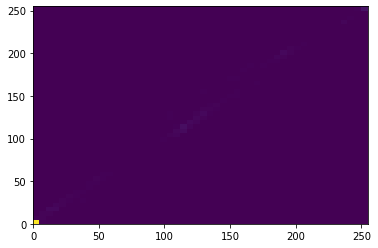

In [7]:
pixel_matrix = np.reshape(first, (dims[0] * dims[1], dims[2]))
print(np.shape(pixel_matrix))
plot.hist2d(pixel_matrix[:,1], pixel_matrix[:,2], bins=(50,50))

<div class="alert alert-block alert-info">
Observe basic property of one image then we we will compute dataset global values. 
</div

Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (128, 128, 3)
Image Hight 128
Image Width 128
Dimension of Image 3
Image size 49152
Maximum RGB value in this image 255
Minimum RGB value in this image 0


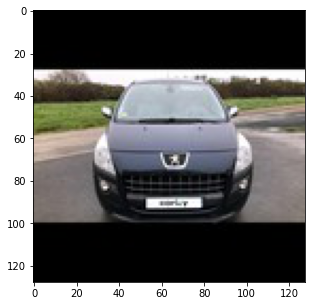

In [8]:
 plot.figure(figsize = (5,5))
 plot.imshow(first)
print('Type of the image : ' , type(first)) 
print('Shape of the image : {}'.format(first.shape)) 
print('Image Hight {}'.format(first.shape[0])) 
print('Image Width {}'.format(first.shape[1])) 
print('Dimension of Image {}'.format(first.ndim))
print('Image size {}'.format(first.size)) 
print('Maximum RGB value in this image {}'.format(first.max()))
print('Minimum RGB value in this image {}'.format(first.min()))  
                                                                                                              
                                                                                                                
                                                                                                                
                                                                                                              

<div class="alert alert-block alert-success">
The shape of the ndarray shows that it is a three-layered matrix. The first two numbers here are length and width, and the third number (i.e. 3) is for three layers: Red, Green, Blue. So, if we calculate the size of an RGB image, the total size will be counted as height x width x 3
</div>

<div class="alert alert-block alert-info">
Okay, now let’s take a quick view of each channel in the whole image.
</div>

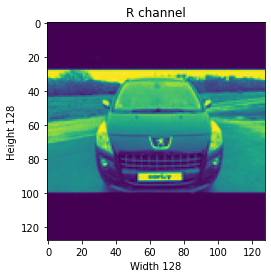

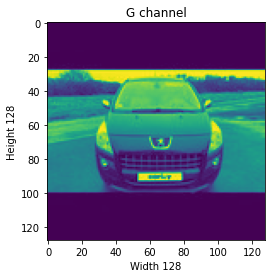

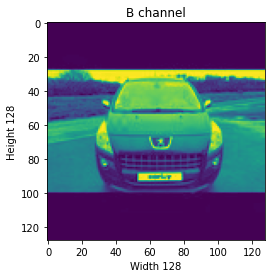

In [9]:
plot.title('R channel') 
plot.ylabel('Height {}'.format(first.shape[0])) 
plot.xlabel('Width {}'.format(first.shape[1])) 
plot.imshow(first[ : , : , 0])
plot.show()
plot.title('G channel')
plot.ylabel('Height {}'.format(first.shape[0])) 
plot.xlabel('Width {}'.format(first.shape[1])) 
plot.imshow(first[ : , : , 1]) 
plot.show()
plot.title('B channel') 
plot.ylabel('Height {}'.format(first.shape[0])) 
plot.xlabel('Width {}'.format(first.shape[1])) 
plot.imshow(first[ : , : , 2]) 
plot.show()

**Splitting layers**
We are looking for an intersting output on a picture to see if it could be better use for model training

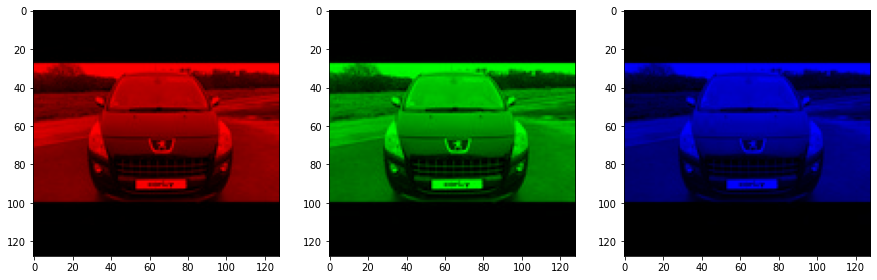

In [10]:
fig, ax = plot.subplots(nrows = 1, ncols=3, figsize=(15,5))  
for c, ax in zip(range(3), ax):     
     # create zero matrix        
     split_img = np.zeros(first.shape, dtype="uint8") 
     # 'dtype' by default: 'numpy.float64'  # assing each channel      
     split_img[ :, :, c] = first[ :, :, c] # display each channel     
     ax.imshow(split_img)

<div class="alert alert-block alert-danger">
Not very interesting. Maybe we could look for a grayscale image. It coulb be used later for computational matters. 
</div>

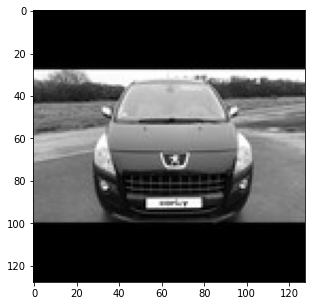

In [11]:
gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114])
gray = gray(first)
plot.figure( figsize = (5,5))  
plot.imshow(gray, cmap = plot.get_cmap(name = 'gray')) 
plot.show()

<div class="alert alert-block alert-info">
The car brand is still recognizable and the logo also. Moreover it reduces the dimension of the np array and it could be a clear advantage to train the model.
</div

<div class="alert alert-block alert-info">
Let's visualize a few image of the dataset just for pleasure.
</div

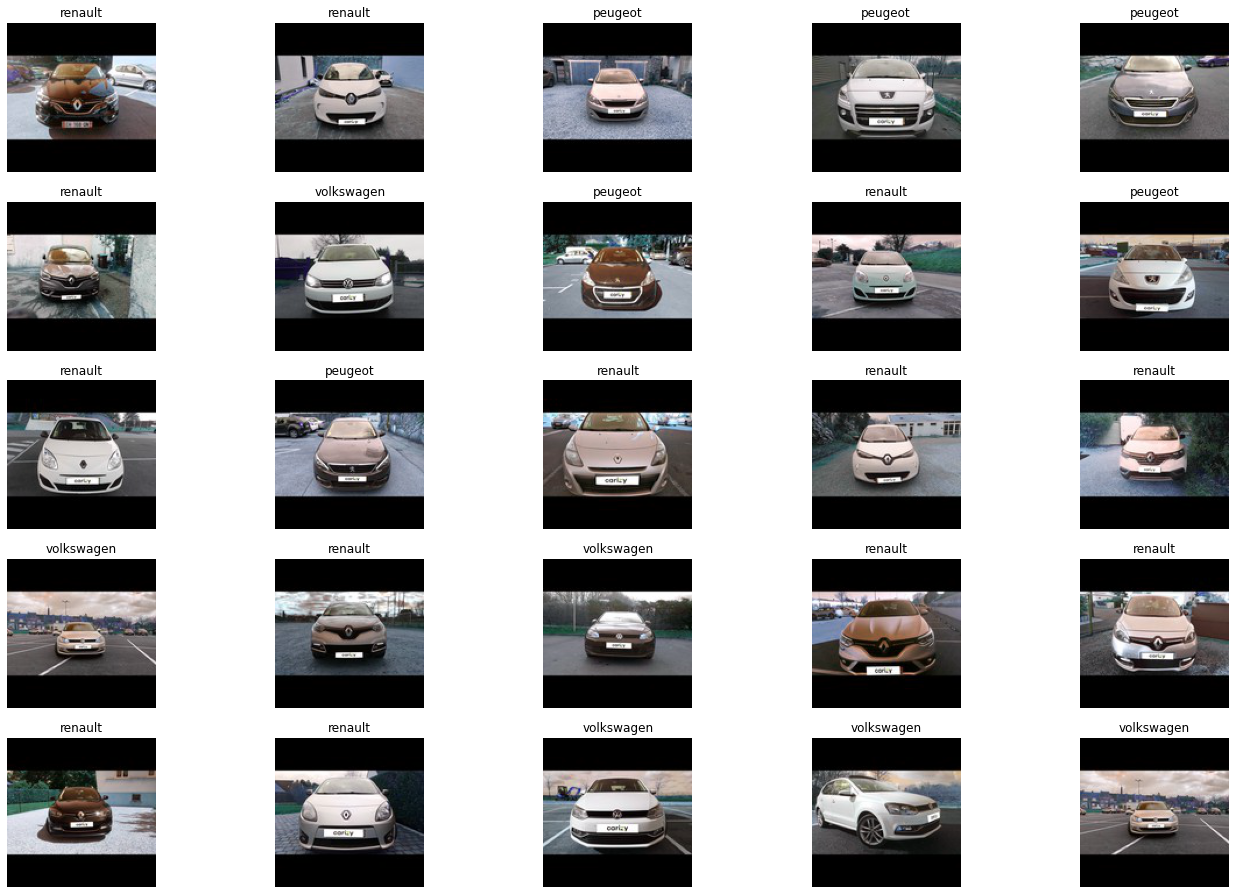

In [12]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(5):
    for j in range(5):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

**Data exploration**
We are now going to visualize the repartition of each car brand with a bar and scatter chart.

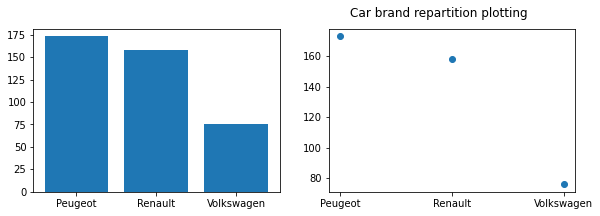

Peugeot : 173 | 42.5%
Renault : 158 | 38.82%
Volkswagen : 76 | 18.67%


In [13]:
unique, counts = np.unique(Labels, return_counts=True)
occurences = np.asarray((unique, counts)).T
names = ['Peugeot', 'Renault', 'Volkswagen']
values = [occurences[0][1], occurences[1][1], occurences[2][1]]
total = Labels.size
plot.figure(figsize=(15, 3))

plot.subplot(131)
plot.bar(names, values)
plot.subplot(132)
plot.scatter(names, values)
plot.suptitle('Car brand repartition plotting')
plot.show()
print("Peugeot : " + str(occurences[0][1]) + " | " + str(int(occurences[0][1] / total * 10000) / 100) + "%")
print("Renault : " + str(occurences[1][1]) + " | " + str(int(occurences[1][1] / total * 10000) / 100) + "%")
print("Volkswagen : " + str(occurences[2][1]) + " | " + str(int(occurences[2][1] / total * 10000) / 100) + "%")


<div class="alert alert-block alert-success">
Regarding those results we are now able to estimate our model efficiency.<br>
If the model predict peugeot less than the random (42.5%) then it won't be good enough for example.
</div>

<a id="datapreprocessing"></a>
## 3. Data pre-processing

Since we have already loaded the data in the Images class and the dataset was already normliazed to 128x128 matrix we w'ell start directly label encoding the data  and then splitting the train and validation set.

<a id="3.1"></a>
### 3.1 Label encoding & data prep

Labels are 3 digits numbers from 0 to 2 representing the different classes. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1]).

In [16]:
grayscale_images = Images.mean(axis=-1)
grayscale_images = np.expand_dims(grayscale_images, axis=3)

<a id="3.2"></a>
### 3.2 Split training & validation set


In [58]:
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(grayscale_images, Labels, test_size = 0.2, random_state=random_seed)
print("Splitted train & validation set")

Splitted train & validation set


<div class="alert alert-block alert-success">
I choosed to split the train set in two parts : a small fraction (20%) became the validation set which the model is evaluated and the rest (80%) is used to train the model.
</div>

<a id="4"></a>
## First neural network training

We are now going to start training our first neural network by using three different models:
* Linear Model
* Multi Layer Perceptron
* Support Vector machine

<a id="4.1"></a>
## Linear Model


In [59]:
#Validate inputs shapes
print(Y_train.shape)
print(X_train.shape)
X_val.shape

(325,)
(325, 128, 128, 1)


(82, 128, 128, 1)

In [60]:
# Re shape in single dimension dimension vector in order to be computed by Linear model

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])

In [61]:
X_train = X_train / 255
X_val = X_val / 255

In [62]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
Y_train.shape

(325, 3)

In [83]:
#Parameters
batch_size = 1
nb_epoch = 100

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [81]:

# Build model
model = Sequential([Dense(32, input_dim=16384),
Activation('relu'),Dense(3),Activation('softmax')])
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32)                524320    
_________________________________________________________________
activation_14 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 99        
_________________________________________________________________
activation_15 (Activation)   (None, 3)                 0         
Total params: 524,419
Trainable params: 524,419
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Train
model.fit(X_train, Y_train, epochs=nb_epoch,batch_size=batch_size, validation_data=(X_val, Y_val))

Epoch 1/100
325/325 [==============================] - 0s 1ms/step - loss: 1.1241 - accuracy: 0.4123 - val_loss: 1.0667 - val_accuracy: 0.3780
Epoch 2/100
325/325 [==============================] - 0s 1ms/step - loss: 1.0489 - accuracy: 0.4492 - val_loss: 1.0617 - val_accuracy: 0.3780
Epoch 3/100
325/325 [==============================] - 0s 1ms/step - loss: 1.0439 - accuracy: 0.4369 - val_loss: 1.0629 - val_accuracy: 0.3780
Epoch 4/100
325/325 [==============================] - 0s 1ms/step - loss: 1.0424 - accuracy: 0.4338 - val_loss: 1.0657 - val_accuracy: 0.3780
Epoch 5/100
325/325 [==============================] - 0s 1ms/step - loss: 1.0416 - accuracy: 0.4369 - val_loss: 1.0663 - val_accuracy: 0.3780
Epoch 6/100
325/325 [==============================] - 0s 1ms/step - loss: 1.0425 - accuracy: 0.4338 - val_loss: 1.0677 - val_accuracy: 0.3780
Epoch 7/100
325/325 [==============================] - 0s 1ms/step - loss: 1.0423 - accuracy: 0.4338 - val_loss: 1.0672 - val_accuracy: 0.3780

Epoch 58/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9342 - accuracy: 0.5015 - val_loss: 1.1965 - val_accuracy: 0.3659
Epoch 59/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9352 - accuracy: 0.4923 - val_loss: 1.2165 - val_accuracy: 0.3902
Epoch 60/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9339 - accuracy: 0.4985 - val_loss: 1.1867 - val_accuracy: 0.3780
Epoch 61/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9337 - accuracy: 0.4985 - val_loss: 1.2068 - val_accuracy: 0.3659
Epoch 62/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9334 - accuracy: 0.4985 - val_loss: 1.2198 - val_accuracy: 0.3902
Epoch 63/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9333 - accuracy: 0.4985 - val_loss: 1.2326 - val_accuracy: 0.3902
Epoch 64/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9323 - accuracy: 0.4985 - val_loss: 1.2194 - val_accuracy:

In [100]:
%matplotlib notebook
import matplotlib.pyplot as plot
def plot_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plot.legend()
    plot.grid()
    fig.canvas.draw()

Test score: 1.622711420059204
Test accuracy: 0.3658536672592163


<IPython.core.display.Javascript object>


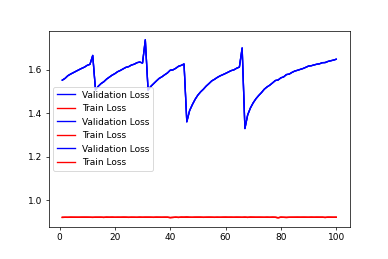

Epoch 1/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9199 - accuracy: 0.5046 - val_loss: 1.5531 - val_accuracy: 0.3537
Epoch 2/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9202 - accuracy: 0.5015 - val_loss: 1.5613 - val_accuracy: 0.3537
Epoch 3/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9201 - accuracy: 0.4954 - val_loss: 1.5735 - val_accuracy: 0.3537
Epoch 4/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9204 - accuracy: 0.5015 - val_loss: 1.5811 - val_accuracy: 0.3537
Epoch 5/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9203 - accuracy: 0.5015 - val_loss: 1.5877 - val_accuracy: 0.3537
Epoch 6/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9203 - accuracy: 0.5015 - val_loss: 1.5944 - val_accuracy: 0.3537
Epoch 7/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9202 - accuracy: 0.5015 - val_loss: 1.6010 - val_accuracy: 0.3659

Epoch 58/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9202 - accuracy: 0.5015 - val_loss: 1.5727 - val_accuracy: 0.3415
Epoch 59/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9205 - accuracy: 0.5015 - val_loss: 1.5783 - val_accuracy: 0.3537
Epoch 60/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9206 - accuracy: 0.5015 - val_loss: 1.5841 - val_accuracy: 0.3537
Epoch 61/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9203 - accuracy: 0.5015 - val_loss: 1.5904 - val_accuracy: 0.3537
Epoch 62/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9205 - accuracy: 0.5015 - val_loss: 1.5970 - val_accuracy: 0.3537
Epoch 63/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9202 - accuracy: 0.5015 - val_loss: 1.6005 - val_accuracy: 0.3537
Epoch 64/100
325/325 [==============================] - 0s 1ms/step - loss: 0.9205 - accuracy: 0.5015 - val_loss: 1.6080 - val_accuracy:

In [102]:
score = model.evaluate(X_val, Y_val, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Categorical Crossentropy Loss"
x= list(range(1, nb_epoch+1))
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, Y_val))
vy = history.history['val_loss']
ty = history.history['loss']




In [104]:
plot_view(x, vy, ty, ax)